<a href="https://colab.research.google.com/github/fleshgordo/sensinglikeamultiplicity/blob/main/day1/HFT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HFT antenna investigation

A satellite imagery analysis of antenna infrastructures used by HFT trading companies between Frankfurt and London stockexchange will be described here. Data is provided through a KML file which is filtered for geo-coordinates. Satellite images will be eventually scraped with python's request library.

First, let's install some additional modules:

In [ ]:
!pip install geopandas
!pip install pykml

Some modules need to be imported, namely [Geopandas](https://geopandas.org/en/stable/) for handling geopositiong data extending the functionalities of [pandas](https://pandas.pydata.org/) 

In [ ]:
import geopandas as gpd 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time

## Reading the KML file

The KML file was tediously crafted in the past years by Alexandre Laumonnier who runs the blog [Sniper In Mahwah](https://sniperinmahwah.wordpress.com/). He combined research for radio licences, interviewed companies and did fieldtrips to those specific sites. The [book 4](https://visionscarto.net/enquete-reseaux-hft) gives insights into his ethnographic study of HFT trading.

First, the KML file needs to be parsed. To get an idea of its content, one can import the KML file into [Google earth](https://earth.google.com/) and already see the placemarks, lines and information (click on Project left-hand side -> new project -> Import KML file from computer).

With the python library [pykml](https://pythonhosted.org/pykml/) placemarks, lines and other tree elements can be easily parsed. Placemarks will be stored in a variable `pms` and the line connections in `lines`.

In [ ]:
from pykml import parser

# Read the KML file into a string
with open('data/doc.kml', 'r', encoding="utf-8") as f:
    root = parser.parse(f).getroot()

pms = root.findall('.//{http://www.opengis.net/kml/2.2}Placemark') # get placemarks 
lines = root.findall('.//{http://www.opengis.net/kml/2.2}LineString') # get line connections
#lines

After extracting the placemarks one can look into the new array `pms`:

In [ ]:
print(pms[0].LookAt.latitude)
print(pms[0].LookAt.longitude)
print(pms[0].name)

51.5861754722526
0.4856713773734156
LATENT-GETCO


The pykml object isn't really handy to continue further analysis, hence we are going to iterate through the `locations` object and prepare to add it to a proper pandas dataframe:

In [ ]:
locations = []

for pm in pms:
    try:
        locations.append({"latitude": pm.LookAt.latitude, "longitude": pm.LookAt.longitude, "name": pm.name})
        #print(f"name: {pm.name} lat: {pm.LookAt.latitude} lon: {pm.LookAt.longitude}")
    except:
        pass
        #print("---")


gdf = gpd.GeoDataFrame(columns=['latitude', 'longitude'])
        
for location in locations:
    gdf = gdf.append(location, ignore_index=True)

gdf

,latitude,longitude,name
0,[[[51.5861754722526]]],[[[0.4856713773734156]]],[[[LATENT-GETCO]]]
1,[[[51.55126667237946]]],[[[0.5814261826552358]]],[[[LATENT-GETCO]]]
2,[[[50.9310485733624]]],[[[2.348702802067737]]],[[[Latent]]]
3,[[[50.14319461048485]]],[[[8.741516010102837]]],[[[Deutshe Bourse Equinix]]]
4,[[[51.010456181187]]],[[[2.579202948409087]]],[[[JUMP]]]
...,...,...,...
924,[[[51.00786426082238]]],[[[-2.186859190170183]]],[[[New Line Networks]]]
925,[[[51.30796292118617]]],[[[-1.244850300510069]]],[[[New Line Networks]]]
926,[[[51.4921503325563]]],[[[-0.1256679579025788]]],[[[New Line Networks]]]
927,[[[51.48861163270006]]],[[[-0.03558808529131375]]],[[[New Line Networks]]]


## Filtering

The kml file has still to many locations (some US, Canadian HFT trading site are mapped there as well). Next step is filtering on a geographic bound area:

In [ ]:
# focus only on specific range in europe lat < 60 && > 40, long > -5 && long < 15
hdf = gdf[(gdf["latitude"] < 60) & (gdf["latitude"] > 40) & (gdf["longitude"] > -5) & (gdf["longitude"] < 15 )]
hdf = hdf.reset_index()
hdf

,index,latitude,longitude,name
0,0,[[[51.5861754722526]]],[[[0.4856713773734156]]],[[[LATENT-GETCO]]]
1,1,[[[51.55126667237946]]],[[[0.5814261826552358]]],[[[LATENT-GETCO]]]
2,2,[[[50.9310485733624]]],[[[2.348702802067737]]],[[[Latent]]]
3,3,[[[50.14319461048485]]],[[[8.741516010102837]]],[[[Deutshe Bourse Equinix]]]
4,4,[[[51.010456181187]]],[[[2.579202948409087]]],[[[JUMP]]]
...,...,...,...,...
456,924,[[[51.00786426082238]]],[[[-2.186859190170183]]],[[[New Line Networks]]]
457,925,[[[51.30796292118617]]],[[[-1.244850300510069]]],[[[New Line Networks]]]
458,926,[[[51.4921503325563]]],[[[-0.1256679579025788]]],[[[New Line Networks]]]
459,927,[[[51.48861163270006]]],[[[-0.03558808529131375]]],[[[New Line Networks]]]


At some locations, multiple operators are renting the same tower/building. Removing of duplicate entries (same lat/lon coordinates)

In [ ]:
duplicate_rows = hdf[hdf.duplicated(subset=['latitude', 'longitude'])]
#duplicate_rows
row_count = duplicate_rows.shape[0]
row_count_hdf = hdf.shape[0]
print(f"The are {row_count} duplicates on the same location out of {row_count_hdf} locations")

The are 59 duplicates on the same location out of 461 locations


In [ ]:
hdf = hdf.drop_duplicates(subset=['latitude', 'longitude'])
print(f"total locations after duplicate removal: {hdf.shape[0]}")

total locations after duplicate removal: 402


## Plotting

With matplot we are looking at our placemarks:

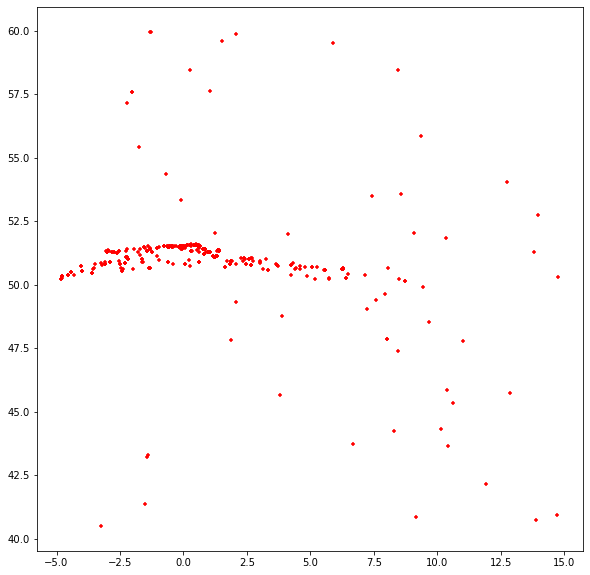

In [ ]:
hdf_plot = gpd.GeoDataFrame(hdf, geometry=gpd.points_from_xy(hdf.longitude, hdf.latitude))
ax= hdf_plot.plot(figsize=(20, 10),marker='+', color='red', markersize=10)

# Plot the GeoDataFrame
plt.show()

## Scraping satellite images

Generate google maps links for testing our coordinates:

In [ ]:
lat = 15.25620994208186
lon = 44.1783455789253

url = f"https://www.google.com/maps/@{lat},{lon},246m/data=!3m1!1e3"
print(url)

https://www.google.com/maps/@15.25620994208186,44.1783455789253,246m/data=!3m1!1e3


For fetching satellite images from Google, you'll need to use a Google developer API key that is enabled for the [Google Maps API](https://developers.google.com/maps). An example URL to fetch a satellite image might look like this:

```
https://maps.googleapis.com/maps/api/staticmap?key=YOURAPIKEY&center=51.32520226530075,-2.91801722601044&zoom=19&maptype=satellite&size=600x600
```

The parameters are mostly self-explanatory. You can define tilesize, map layout and zoom level.

In [ ]:
import requests 
import os

# general map params
key = "YOUR_API_KEY" # API key for google maps
zoom = 19 # max 18 but satellite gives sometimes more, depends on provider
maptype = "satellite"
size = "600x600"

# misc params
outputfolder = "./output"
start_no = 0 # set this to 0 for first run, or to other number to resume a download operation

download = False # set this to True to batch download ...

for ind in gdf.loc[start_no:].index:
    lat = gdf['latitude'][ind]
    lon = gdf['longitude'][ind]
    center = f"{lat},{lon}"
    gurl = f"https://maps.googleapis.com/maps/api/staticmap?key={key}&center={center}&zoom={zoom}&maptype={maptype}&size={size}"
    filename = f"{str(ind).zfill(4)}_{gdf['name'][ind]}.jpg" # zero padding the filenames, 0001, 0002, 0003 etc..
    filename = os.path.join(outputfolder,filename.replace(" ", "-").replace("/", "").replace("|","\|")) # some cleanup to prevent / in filenames
    print(f"getting from url: {gurl} and saving to: {filename}")
    if download == True:
        response = requests.get(gurl)
        image_content = response.content
        image_file = open(filename, "wb")
        image_file.write(image_content)
        image_file.close()
        time.sleep(2)

getting from url: https://maps.googleapis.com/maps/api/staticmap?key=&center=51.5861754722526,0.4856713773734156&zoom=19&maptype=satellite&size=600x600 and saving to: ./output/0000_LATENT-GETCO.jpg
getting from url: https://maps.googleapis.com/maps/api/staticmap?key=&center=51.55126667237946,0.5814261826552358&zoom=19&maptype=satellite&size=600x600 and saving to: ./output/0001_LATENT-GETCO.jpg
getting from url: https://maps.googleapis.com/maps/api/staticmap?key=&center=50.9310485733624,2.348702802067737&zoom=19&maptype=satellite&size=600x600 and saving to: ./output/0002_Latent.jpg
getting from url: https://maps.googleapis.com/maps/api/staticmap?key=&center=50.14319461048485,8.741516010102837&zoom=19&maptype=satellite&size=600x600 and saving to: ./output/0003_Deutshe-Bourse-Equinix.jpg
getting from url: https://maps.googleapis.com/maps/api/staticmap?key=&center=51.010456181187,2.579202948409087&zoom=19&maptype=satellite&size=600x600 and saving to: ./output/0004_JUMP.jpg
getting from url